In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

# Classification on German Credit

### Data and Models

In [2]:
### Get data and fit a pool of classifiers on it

#X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='german', test_size=0.28)

print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

(720, 63) 0.7055555555555556


In [3]:
pool1 = pool.BasicPool()#models=["SVMrbf", "RF200", "LR", "XGB", "GB"])
pool1 = pool1.fit(X_train.values, y_train)
pool1 = pool1.filter_accuracies(X_test, y_test, 0.05)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score

print("Accuracies (F1): ", {c: f1_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())



"""from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix


classifiers = [v for k, v in pool1.models.items()]#[pool1.models["SVMrbf"], pool1.models["RF200"]]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

    
#plot_roc_curve(pool1.models["SVMrbf"], X_test, y_test)
#plot_roc_curve(pool1.models["RF200"], X_test, y_test)

for i in classifiers:
    plot_confusion_matrix(i, X_test, y_test, normalize='all')
    plt.show()
"""

[11:35:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'SVMrbf': 0.8368794326241135, 'RF100': 0.8187633262260127, 'RF200': 0.8348623853211009, 'KNN5': 0.8179775280898876, 'XGB': 0.820253164556962, 'LR': 0.811881188118812, 'GB': 0.8168316831683169}
Discrepancies on train: 0.3541666666666667
Discrepancies on test: 0.36428571428571427


'from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix\n\n\nclassifiers = [v for k, v in pool1.models.items()]#[pool1.models["SVMrbf"], pool1.models["RF200"]]\nax = plt.gca()\nfor i in classifiers:\n    plot_roc_curve(i, X_test, y_test, ax=ax)\n\n    \n#plot_roc_curve(pool1.models["SVMrbf"], X_test, y_test)\n#plot_roc_curve(pool1.models["RF200"], X_test, y_test)\n\nfor i in classifiers:\n    plot_confusion_matrix(i, X_test, y_test, normalize=\'all\')\n    plt.show()\n'

## Training DIG

### Learning the graph

In [4]:
%%time 
p2g = pool2graph_cat_FJ2_2.pool2graph(X_train, y_train, pool1, k_init=10, categorical_names=cat_names)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=5)#5?
print(len(p2g.G.nodes))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


134152
CPU times: user 2min 15s, sys: 12.4 s, total: 2min 27s
Wall time: 1min 40s


### Refining intervals

In [5]:
%%time
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

18215
CPU times: user 20.4 s, sys: 91.7 ms, total: 20.5 s
Wall time: 20.6 s


# Global analysis of the intervals

In [6]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global

In [7]:
### we work with that    
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (18215, 63)
Input data preprocessed (self.X): shape (720, 64)
Discrepancy nodes dataset (self.nodes_dataset): shape (111938, 63)
Nodes dataset (self.nodes_dataset): shape (134152, 64)


### Deep dive on one instance

In [31]:
# Let's pick an instance for which classifiers disagree
idx_disag = np.where(pool1.predict_discrepancies(X_test) == 1)[0][0]
idx_disag

0

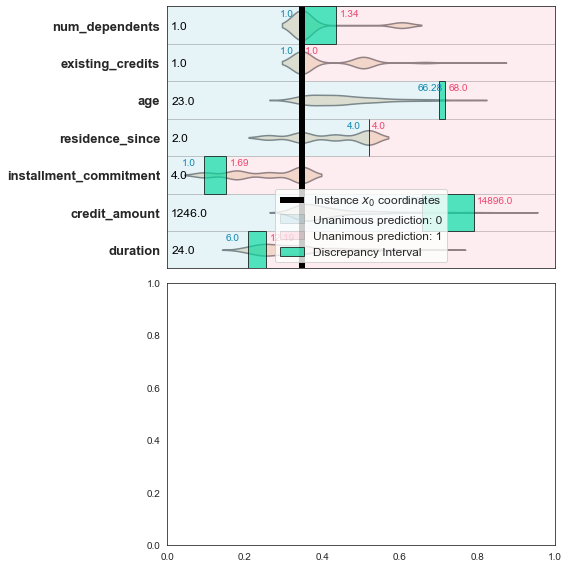

<Figure size 432x288 with 0 Axes>

In [33]:
# local interval of discrepancy 

instance = X_test.iloc[idx_disag, :]
instance[cat_names] = (instance[cat_names] > 0.0).astype("int")

gda.local_intervals(instance, intervals, scaler, k=1) #### Categorical to fix --> hardcoded cat names

### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> pas sûr qu'il faille normaliser par ça... car intercalle = 2 pts, X_train= chaque pt


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
#fname = '../../results/feature_importances_adult.pdf'
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')


## Important areas of discrepancy

In [ ]:
%%time
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.7, min_purity_expo=0.0)



In [11]:
np.where(pool1.predict_discrepancies(X_test) == 1)

idx = 9
#5


instance = X_test.iloc[idx, :]
instance[cat_names] = (instance[cat_names] > 0.0).astype("int")
from sklearn.metrics import pairwise_distances_argmin_min
idx_closest, _ = pairwise_distances_argmin_min(instance.values.reshape(1, -1), gda.disc_nodes_dataset)
idx_closest = gda.disc_nodes_dataset.iloc[idx_closest].index
print(idx_closest)
##on tente ici de faire filtre categorielles
#idx_closest, min_ = pairwise_distances_argmin_min(instance[cat_names].values.reshape(1, -1), gda.disc_nodes_dataset[cat_names])
#print(idx_closest, min_)
#idx_closest = gda.disc_nodes_dataset.iloc[idx_closest].index

for ci in intervals:
    if idx_closest in list(ci.path):
        interval_relevant = ci.border_features
        break


Int64Index([-78220], dtype='int64')


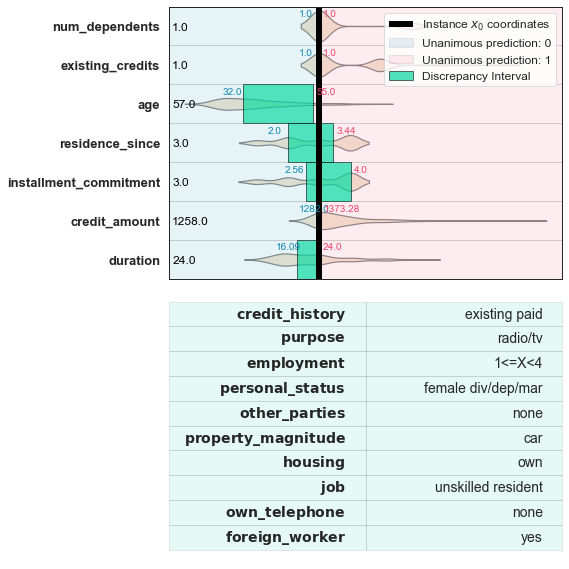